# Tesco Creative Extension Project

## Table of Contents:
1. [Useful functions](#first-bullet)
    * [Housing](#house)
    * [Income](#income)
    * [Jobs](#jobs)
    * [Community](#community)
    * [Education](#education)
    * [Environment](#env)
    * [Civic Engagement](#civic)
    * [Health](#health)
    * [Life Satisfaction](#satisfaction)
    * [Safety](#safety)
    * [Work-Life Balance](#balance)
    * [Food](#food)
2. [data preprocessing](#second-bullet)

3. [PCA](#3-bullet)

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## useful functions data preprocessing <a class="anchor" id="first-bullet"></a>
in this section we define useful functions to help us in our data preprocessing pipeline:

In [306]:
#Can choose between 'standardize' (xi - mean)/std or 're_scale' (rescales between 0 and 1), also can remove outliers or not
# must be a list though, if remove all outliers just [True] or [False], if some columns yes and others no : [True, False...]
# must match 'columns' lenght. (can be only 1 column) 

def normalize(df,method='standardize', remove_outliers = [True]):
    """function that will allow us to normalize the data, using different methods, and remove outliers (or not).  """
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2
        
    if len(remove_outliers) == 1 :
        remove_outliers = remove_outliers*data.shape[1]
    elif len(remove_outliers) != data.shape[1] : print('Warning, remove_outliers size should match the one of colums')
        
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers[i] :
            #remove outliers
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

## Data Pre-processing <a class="anchor" id="second-bullet"></a>

In [307]:
#importing the correct data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
ward_total_wellbeing = pd.read_csv('data/total_stats_ward.csv') #serves as validation set (Sort of)

In [308]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna()
ward_demographics = ward_demographics.dropna(axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna()

In [309]:
#rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property, 'foods':ward_tesco}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

We need to create 11 different indicators + 1 with the food. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance

**Housing**

<a class="anchor" id="house"></a>
To create our indicators we need our different categories.
**Housing** : 
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `people_per_sq_km` and we use a way of measuring what types of housing are in the wards : `detached_house`, `semi_detached_house`, `terraced_house` and `apartment`. We are working under the assumption that a house is larger than an apartment and therefore brings less density. 
- need an access to an indoor private flushing toilet --> this is not very pertinent to our dataset. 
- need way of measuring housing expenditure: --> we employ the median house price `median_house_price`


In [310]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names",
                "Median House Price 2014",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

housing.rename(columns={"Median House Price 2014":"median_house_price",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached":"detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached":"semi_detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced":"terraced_house",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment":"apartment"}, inplace=True)

In [311]:
housing = housing.merge(ward_tesco, on='area_id', how='inner')

In [312]:
#keep only wanted rows
column_names = ["area_id","Names","median_house_price","people_per_sq_km","detached_house","semi_detached_house",
               "terraced_house","apartment"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [313]:
#normalize the data by rescaling
housing = normalize(housing, 're_scale',remove_outliers = [True])

In [314]:
#we take the complement of certain values if a higher value indicates a negative influence.
#i.e a higher value for an unemployment rate indicates a "bad" factor. By taking the complement,
#we instead measure the employment rate 
housing["people_per_sq_km"]= 1-housing["people_per_sq_km"]

In [315]:
housing.head(3)

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000026,Abbey,0.0,0.434983,0.105019,0.106040,0.356427,0.460527
1,E05000027,Alibon,0.0,0.628318,0.084301,0.254829,1.000000,0.009179
2,E05000028,Becontree,0.0,0.472386,0.105019,0.385869,0.869302,0.055207


**Income** <a class="anchor" id="income"></a>


link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income

Here we employ the median income of a ward : `median_income` to measure this

In [316]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = income.merge(ward_tesco, on='area_id', how='inner')

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [317]:
#normalize the data by rescaling
income = normalize(income, 're_scale',remove_outliers = [True])

In [318]:
income.head(3) 

,area_id,median_income
0,E05000026,0.212696
1,E05000027,0.154969
2,E05000028,0.176069


**Jobs** <a class="anchor" id="jobs"></a>


link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed : we use the number of incapacity benefit claimants per year to modelise this (`incapacity_claimants`) as well employment and support allowance (ESA) claimants (`esa_claimants`). ESA gives you: 
1. money to help with living costs if you’re unable to work
2. support to get back into work if you’re able to
3. You can apply for ESA if you’re employed, self-employed or unemployed.


* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months) -- we use JSA claiment rates (`jsa_claimants`), which is short for Jobseekers allowance claim, you are eligible if you are actively seeking a job and are of pensionable age. 
* employment rate (`employment_rate_16-64`)

In [319]:
#code here
column_names = ['area_id', "Employment rate (16-64) 2011", "Incapacity Benefit Claimants 2014",
               "Employment and support allowance claimants 2014",
                "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)

jobs = jobs.merge(ward_tesco, on='area_id', how='inner')
jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64",
                     "Incapacity Benefit Claimants 2014":'incapacity__claimants',
               "Employment and support allowance claimants 2014": "esa_claimants",
                "JSA Claimant Rate 2015": "jsa_claimants"}, inplace=True)

In [320]:
#normalize the data by rescaling
jobs = normalize(jobs, 're_scale',remove_outliers = [True])

jobs['jsa_claimants'] = 1 - jobs['jsa_claimants']
#we'll see if we do this inverse operation for incapacity and esa claiments


In [321]:
jobs.head(3)

,area_id,employment_rate_16-64,incapacity__claimants,esa_claimants,jsa_claimants
0,E05000026,0.179972,0.322581,0.424559,0.250000
1,E05000027,0.292580,0.580645,0.532589,0.318182
2,E05000028,0.216167,0.516129,0.597407,0.340909


**Community** <a class="anchor" id="community"></a>


link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we do not have the data required for this, so instead we are evaluating the richness of community diversity by 3 factors:

`diversity_ratio` -- which is a measure of the ethnical diversity in a ward. 

`religion_ratio` -- which is a measure of the religious diversity in a ward. 

`no_english_main_language` -- which counts the amount of households who do not have a english-speaker inside it.

In [322]:
#code here
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other",
               "Household Language - 2011 Census No people in household have English as a main language",
               "Religion - 2011 Census Christian","Religion - 2011 Census Buddhist","Religion - 2011 Census Hindu",
               "Religion - 2011 Census Jewish","Religion - 2011 Census Muslim","Religion - 2011 Census Sikh", 
               "Religion - 2011 Census Other religions",
                "Religion - 2011 Census No religion"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = community.merge(ward_tesco, on='area_id', how='inner')
community = community[column_names]
community.rename(columns= {"Ethnic Group 5 groups - 2011 Census White":'white', "Ethnic Group 5 groups - 2011 Census Mixed":'mixed', 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British":'asian', 
                           "Ethnic Group 5 groups - 2011 Census Black or Black British":'black',
               "Ethnic Group 5 groups - 2011 Census Other":'other_ethnic',
               "Household Language - 2011 Census No people in household have English as a main language":'no_english_main_language',
               "Religion - 2011 Census Christian":'christian',"Religion - 2011 Census Buddhist":'buddhist',"Religion - 2011 Census Hindu":'hindu',
               "Religion - 2011 Census Jewish":'jewish',"Religion - 2011 Census Muslim":'muslim',"Religion - 2011 Census Sikh":'sikh', 
               "Religion - 2011 Census Other religions":'other',
                "Religion - 2011 Census No religion":'no_religion'},
                 inplace=True)

our diversity ratio is defined as white to all other races. Our religious diversity is defined as the christian and no religion stated to all other religions ratio.

In [323]:
community = community.assign(diversity_ratio = community['white']/
                             (community['mixed']+community['asian']+community['black']+community['other_ethnic']))
community = community.assign(religion_ratio = (community['christian']+community['no_religion'])/
                             (community['buddhist']+community['hindu']+community['jewish']+community['muslim']+
                             community['sikh']+community['other']))

In [324]:
 community = community[['area_id','no_english_main_language','diversity_ratio', 'religion_ratio']]

In [325]:
#normalize the data by rescaling
community = normalize(community, 're_scale',remove_outliers = [True])

community['no_english_main_language'] = 1 - community['no_english_main_language']

In [326]:
community.head(3)

,area_id,no_english_main_language,diversity_ratio,religion_ratio
0,E05000026,0.217961,0.017756,0.022245
1,E05000027,0.835578,0.231626,0.498317
2,E05000028,0.737908,0.131520,0.165679


**Education** <a class="anchor" id="education"></a>

link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school `unauthorised_school_abscence`
* student skills -- average performance of student here GCSE `GCSE_score`
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education `higher_education` 

to obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

In [327]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = education.merge(ward_tesco, on='area_id', how='inner')
education = education[column_names]
education = education.assign(higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [328]:
#normalize the data by rescaling
education = normalize(education, 're_scale',remove_outliers = [True])

education['unauthorised_school_abscence'] = 1 - education['unauthorised_school_abscence']

In [329]:
education.head(3)

,area_id,GCSE_score,unauthorised_school_abscence,higher_education
0,E05000026,0.301296,0.285714,0.333976
1,E05000027,0.168726,0.214286,0.000000
2,E05000028,0.024104,0.214286,0.044121


**Environment** <a class="anchor" id="env"></a>


link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

Here, we do not have a way of measuring the water quality (from the dataset we found), so we are instead measuring other air pollution factors such as :
`PM10_mean` 
`NO2_mean`

additionally, we are assessing the environment quality by observing whether homes have an easy access to nature : `homes_without_access_nature_%` and counting how much of the area in a ward is a greenspace : `area_greenspace` 

In [330]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011','Annual Mean of Nitrogen Dioxide (NO2) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environment = environment.merge(ward_tesco, on='area_id', how='inner')
environment = environment[column_names]


environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_%',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature_%',
                            'Annual Mean of Nitrogen Dioxide (NO2) 2011': 'NO2_mean'},
                 inplace=True)

In [331]:
#normalize the data by rescaling
environment = normalize(environment, 're_scale',remove_outliers = [True])

environment["PM10_mean"] = 1 - environment["PM10_mean"]
environment['NO2_mean'] = 1 - environment['NO2_mean']
environment['homes_without_access_nature_%'] = 1 - environment['homes_without_access_nature_%']

In [332]:
environment.head(3)

,area_id,PM10_mean,NO2_mean,area_greenspace_%,homes_without_access_nature_%
0,E05000026,0.605463,0.550464,0.278775,0.977947
1,E05000027,0.848255,0.831600,0.259493,0.281275
2,E05000028,0.817906,0.775373,0.000000,0.827586


**Civic Engagement** <a class="anchor" id="civic"></a>


link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections -- modelised by `election_turnout`
* stakeholder engagement for developing regulations -- might be hard to do


In [333]:
#code here
column_names = ['area_id', 'Turnout Borough election 2014' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = civic.merge(ward_tesco, on='area_id', how='inner')
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2014':'election_turnout'}, inplace=True)

In [334]:
#normalize the data by rescaling
civic = normalize(civic, 're_scale',remove_outliers = [True])

In [335]:
civic.head(3)

,area_id,election_turnout
0,E05000026,0.359061
1,E05000027,0.228683
2,E05000028,0.359061


**Health** <a class="anchor" id="health"></a>


link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy -- modeled by `life_expectancy`
* self-reported health (kind of hard) -- modeled by a survey to which people answered if they were in bad health : `people_with_bad_health_percent`

In [336]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = health.merge(ward_tesco, on='area_id', how='inner')
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [337]:
#normalize the data by rescaling
health = normalize(health, 're_scale',remove_outliers = [True])

health['people_with_bad_health_percent'] = 1- health['people_with_bad_health_percent']

In [338]:
health.head(3)

,area_id,life_expectancy,people_with_bad_health_percent
0,E05000026,0.475900,0.645833
1,E05000027,0.109823,0.145833
2,E05000028,0.134228,0.083333


**Life Satisfaction** <a class="anchor" id="satisfaction"></a>


link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? -- modelised by the answer to that survey `how_satisfied_are_you_score`

In [339]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = life_satisfaction.merge(ward_tesco, on='area_id', how='inner')
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [340]:
#normalize the data by rescaling
life_satisfaction = normalize(life_satisfaction, 're_scale',remove_outliers = [True])

In [341]:
life_satisfaction.head(3)

,area_id,how_satisfied_are_you_score
0,E05000026,0.748954
1,E05000027,0.330544
2,E05000028,0.497908


**Safety** <a class="anchor" id="safety"></a>


link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) 

Here we use a couple of variables to modelise whether one is feeling safe walking alone at night. We include the counts of theft, robbery, burglary, sexual offence, violence against the person and arsenal rate to modelise this. There are found in the following variables:
`theft_incidents`
`robbery_incidents`
`sexual_offences_incidents`
`violence_against_person_incidents`
`aresenal_incidents`

we also use the `crime_rate` to modelise the homicide rate. 

To answer the question "do you feel safe walking alone at night" we keep the above criminal counts as different categories. We will later combine them if it is significant to do so. 

In [342]:
# code here
column_names = ['area_id','Deliberate Fires per 1,000 population 2014', 'Drugs 2014/15', 'Theft and Handling 2014/15',
                'Burglary 2014/15', 'Robbery 2014/15', 'Sexual offences 2014/15', 'Violence against the person 2014/15',
                'Total crime rate 2014/15']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = safety.merge(ward_tesco, on='area_id', how='inner')
safety = safety[column_names]

safety.rename(columns={'Deliberate Fires per 1,000 population 2014':'arsenal_incidents',
                      'Total crime rate 2014/15':'crime_rate',
                      'Drugs 2014/15':'drug_incidents', 'Theft and Handling 2014/15':'theft_incidents',
                       'Burglary 2014/15':'burglary_incidents', 'Robbery 2014/15':'robbery_incidents', 
                       'Sexual offences 2014/15':'sexual_offences_incidents', 
                       'Violence against the person 2014/15':'violence_against_person_incidents'}, 
              inplace=True)


In [343]:
#normalize the data by rescaling
safety = normalize(safety, 're_scale',remove_outliers = [True])

safety['arsenal_incidents'] = 1- safety['arsenal_incidents']
safety['crime_rate'] = 1 - safety['crime_rate'] 
safety['theft_incidents'] = 1 - safety['theft_incidents']
safety['robbery_incidents'] = 1 - safety['robbery_incidents']
safety['sexual_offences_incidents'] = 1 - safety['sexual_offences_incidents']
safety['violence_against_person_incidents'] = 1 - safety['violence_against_person_incidents']

In [344]:
safety.head(3)

,area_id,arsenal_incidents,drug_incidents,theft_incidents,burglary_incidents,robbery_incidents,sexual_offences_incidents,violence_against_person_incidents,crime_rate
0,E05000026,0.133333,0.637694,0.509956,0.158582,0.473684,0.138533,0.151468,0.372841
1,E05000027,0.533333,0.200917,0.936652,0.135887,0.810526,0.557625,0.674364,0.759625
2,E05000028,0.200000,0.157240,0.881947,0.499007,0.705263,0.557625,0.577299,0.721846


**Work-Life Balance** <a class="anchor" id="balance"></a>


link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

We model this by `part_time_employee_percent`

Here, we will employ the number of part-time employees. This can be used to model how much less time workers spend at work. 

In [345]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = work_life_balance.merge(ward_tesco, on='area_id', how='inner')
work_life_balance = work_life_balance[column_names]

In [346]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             100*work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [347]:
#normalize the data by rescaling
work_life_balance = normalize(work_life_balance, 're_scale',remove_outliers = [True])

In [348]:
work_life_balance.head(3)

,area_id,part_time_employee_percent
0,E05000026,0.444146
1,E05000027,1.000000
2,E05000028,1.000000


**Food** <a class="anchor" id="food"></a>

lastly, we take care of the **food** indicator. We employ the following categories:
- the same 8 categories employed in the tesco paper :
1. `energy_tot` which corresponds to the total energy obtained on average
2. `energy_fat` -- the energy obtained from fat-containing foods
3. `energy_sugar` -- the energy obtained from sugar-rich foods
4. `energy_saturate` -- the energy obtaiend from saturated fat foods
5. `energy_protein` -- the energy obtained from protein-rich foods
6. `energy_carb` -- the energy obtained from carb-rich foods
7. `energy_fibre` -- the energy obtained from fiber-rich foods
8. `h_nutrients_calories_norm` -- the normalised food entropy 

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include : `f_energy_fat`, `f_energy_saturate`, `f_energy_sugar`, `f_energy_protein`, `f_energy_carb`, `f_energy_fibre`, `f_energy_alcohol`

In [349]:
column_names = ['area_id','energy_tot','energy_fat','energy_saturate', 'energy_sugar','energy_protein','energy_carb',
                'energy_fibre','h_nutrients_calories_norm', 'f_energy_fat', 'f_energy_saturate', 'f_energy_sugar',
                'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

foods = pd.DataFrame(data=master_data["foods"],columns=column_names)

foods = foods.merge(jobs, on='area_id', how='inner') #to obtain the same size of the other dataframes
foods = foods[column_names]

In [350]:
#normalize the data by rescaling
foods = normalize(foods, 're_scale',remove_outliers = [True])

foods['energy_fat'] = 1 - foods['energy_fat']
foods['energy_saturate'] = 1 - foods['energy_saturate']
foods['energy_sugar'] = 1 - foods['energy_sugar']
foods['energy_carb'] = 1-foods['energy_carb']

foods['f_energy_fat'] = 1 - foods['f_energy_fat']
foods['f_energy_saturate'] = 1 - foods['f_energy_saturate']
foods['f_energy_sugar'] = 1 - foods['f_energy_sugar']
foods['f_energy_carb'] = foods['f_energy_carb']
foods['f_energy_alcohol'] = foods['f_energy_alcohol']


In [351]:
foods.head(3)

,area_id,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_energy_fat,f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol
0,E05000026,0.723965,0.232312,0.345773,0.324711,0.284872,0.286711,0.124727,0.108791,0.403865,0.514297,0.399501,0.160333,0.697065,0.087065,0.223237
1,E05000027,0.777470,0.050601,0.547943,0.463524,0.542319,0.369088,0.177423,0.208612,0.222153,0.786092,0.627273,0.306471,0.505816,0.092341,0.267686
2,E05000028,0.715080,0.434545,0.472538,0.409495,0.521116,0.233251,0.179997,0.306764,0.688093,0.644890,0.510467,0.329173,0.797397,0.130898,0.345116


Now, we store all these indicators in a dictionary to easily access them:

In [352]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic_Engagement':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance, 'Foods':foods}

In [353]:
#Now we need to figure out how to score each indicator 

# PCA - Principal Component Analysis <a class="anchor" id="3-bullet"></a>

In [354]:
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Let's first define a couple of functions that will be very useful

First a function to show heatmaps of correlation

In [355]:
def correlations_heatmap(df) :
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = X.shape[1]
    
    fig, ax = plt.subplots(figsize=(n,n))  
    sns.heatmap(X.corr(), annot=True, ax=ax, center = 0)
    plt.show()

Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.
The method is based on the approch described by 'Tools for Composite Indicators Building' page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)


In [356]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approch described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.9: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            if component[j] < 0: # skip negative weights
                continue
            weights_matrix[j][i] = component[j]*component[j]/expl_var_array[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

And finaly we will need a function to apply the weights to the values

In [357]:
def calculate_index_for_df(df, weights):
    
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(index = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'index' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

We can now start computing the weights for each category of indicators. Let's start with housing, first we must see if they are correlated at all, if not it doesn't make sens to compute the weights by pca, we would either need to decide ourselves of each weight to give, according to what indicator we deem more important (or simply have equal weights for all of them)

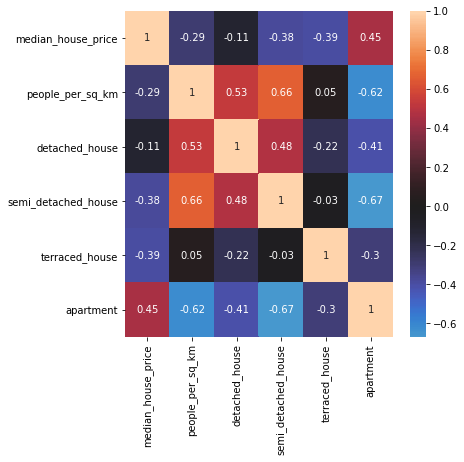

In [358]:
correlations_heatmap(housing)

Avg_rooms per household seems to be not correlated very strongly with any other indicator. remove ? what about area_sq_km ? remove also probably. check p-values ?

Before we can compute the weights, we should normalize the data.

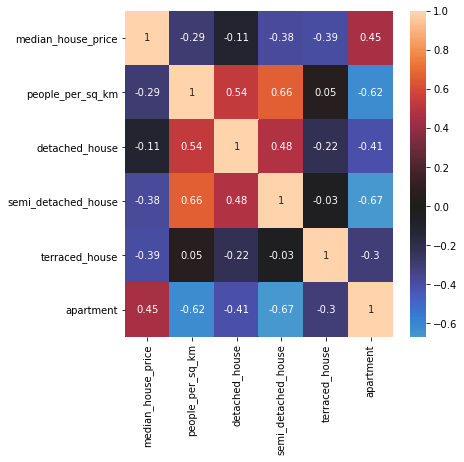

In [359]:
housing_norm = normalize(housing, 're_scale',remove_outliers = [True]) #changes correlations when removing outliers, same otherwise
correlations_heatmap(housing_norm)

In [360]:
housing_weights = calculate_weights(housing_norm)
housing_index = calculate_index_for_df(housing_norm,housing_weights )
print(housing_weights)
housing_index

Component cumulative variance: 49.634017546608455 %
Component cumulative variance: 73.87165200465195 %
Component cumulative variance: 82.73608628923688 %
Component cumulative variance: 89.88540840347717 %
Component cumulative variance: 95.76291668555548 %
                      weights
median_house_price   0.503303
people_per_sq_km     0.071608
detached_house       1.526740
semi_detached_house  0.074235
terraced_house       0.143441
apartment            0.142613


,area_id,Names,index
0,E05000026,Abbey,0.316446
1,E05000027,Alibon,0.337538
2,E05000028,Becontree,0.355610
3,E05000029,Chadwell Heath,0.329781
4,E05000030,Eastbrook,0.318871
...,...,...,...
478,E05000645,Tachbrook,0.453363
479,E05000646,Vincent Square,0.555731
480,E05000647,Warwick,0.570069
481,E05000648,Westbourne,0.314175


Income, life satisaction, civic and work-life balance are all categories were we only have one sub-indicator, so no need to do any pca analysis, we must normalize them however, as well as the rest of the categories.

In [361]:
income_norm = normalize(income, 're_scale') 
life_satisfaction_norm = normalize(life_satisfaction, 're_scale') 
civic_norm = normalize(civic, 're_scale') 
work_life_balance_norm = normalize(work_life_balance, 're_scale') 
community_norm = normalize(community, 're_scale') 
education_norm = normalize(education, 're_scale') 
environment_norm = normalize(environment, 're_scale')  
health_norm = normalize(health, 're_scale') 
safety_norm = normalize(safety, 're_scale') 

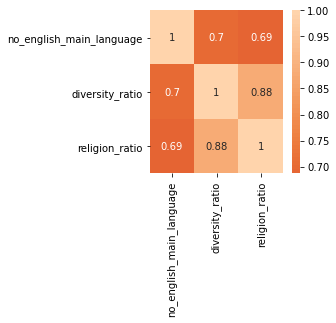

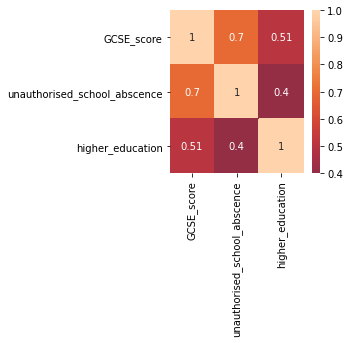

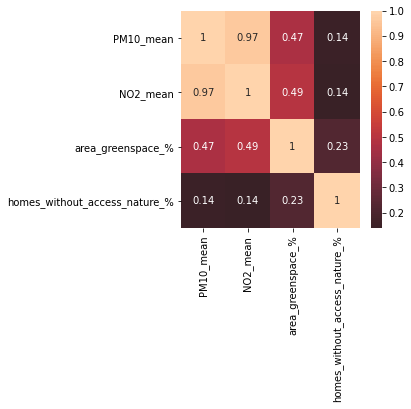

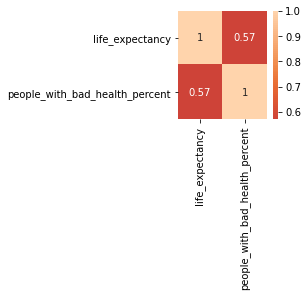

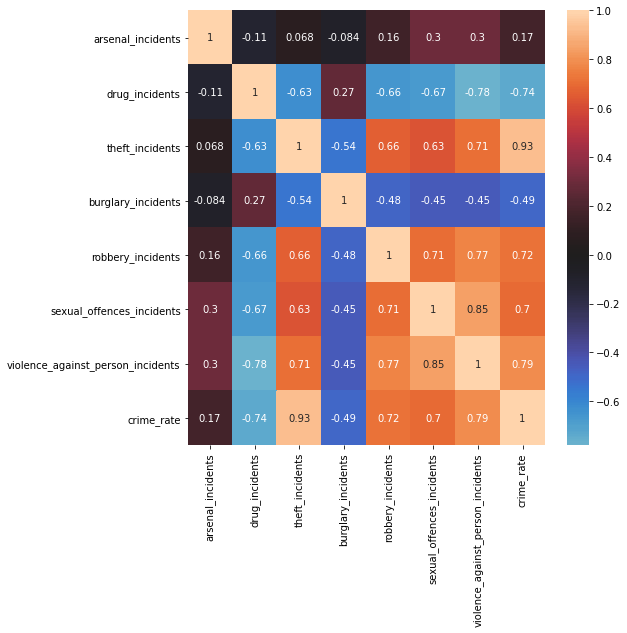

In [362]:
correlations_heatmap(community_norm)
correlations_heatmap(education_norm)
correlations_heatmap(environment_norm)
correlations_heatmap(health_norm)
correlations_heatmap(safety_norm)

In [363]:
safety_weights = calculate_weights(safety_norm)
safety_index = calculate_index_for_df(safety_norm, safety_weights)
safety_weights

Component cumulative variance: 62.626207715556525 %
Component cumulative variance: 75.77851914401289 %
Component cumulative variance: 85.06551464683547 %
Component cumulative variance: 90.48774193200121 %


,weights
arsenal_incidents,0
drug_incidents,0
theft_incidents,0
burglary_incidents,0
robbery_incidents,0
sexual_offences_incidents,0
violence_against_person_incidents,0
crime_rate,0


In [364]:
data_frames = meta_data_indicators.values()

In [78]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['area_id'], how='outer'), list(data_frames))

In [89]:
df_merged.isnull().sum()

area_id                                      0
Names                                        0
median_house_price                           0
population                                   0
area_sq_km_x                                 0
people_per_sq_km                             0
avg_people_per_household                     0
avg_rooms_per_household                      0
household_per_sq_km                          0
household_density                            0
median_income                                0
employment_rate_16-64                        0
one_year_change_unemployment_claim           0
two_year_change_unemployment_claim           0
no_english_main_language                     0
diversity_ratio                              0
english_not_main_language                    0
GCSE_score                                   0
unauthorised_school_abscence_percent         0
percent_higher_education                     0
PM10_mean                                    0
area_greenspa

In [82]:
df_merged = df_merged.fillna(df_merged.mean())

In [166]:
X = df_merged.loc[:, df_merged.columns != 'area_id']
X = X.loc[:, X.columns != 'Names']


NameError: name 'df_merged' is not defined

In [ ]:
def pca(df) :
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    
    p = PCA()
    X_transformed = p.fit_transform(X)

    eigenvalues = p.explained_variance_

    print("Component 1 Values: {}".format(p.components_[0]))
    i = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        i+=1
        cum_variance += eigenvalue
        print("Component {} : {} - Cumulative Variance: {} %".format(i, eigenvalue, 100*cum_variance/sum_variance))